<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/NUIN443_ps7_LDS_extensions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some helper functions for Gaussians
from numpy.random import normal, multivariate_normal
from scipy.stats import norm

#Some scikit learn models we'll be using
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA,FactorAnalysis

#To load the data file
import pickle

## 1) Linear Dynamical Systems on Neural Data


We'll be using the ssm package for fitting state space models (LDS, SLDS, etc). Run the code below to install that package.

In [5]:
#!pip install git+https://github.com/lindermanlab/ssm.git@master#egg=ssm

import ssm

Now we're going to fit an LDS to some real neural data. This is data collected in Lee Miller's lab from motor cortex while a monkey continues to reach to targets across a workspace.
Within a trial, a monkey typically makes 4 reaches (although occasionally less if he makes an error and the trial ends early). After the 4 reaches there is a brief pause while the monkey gets a juice reward. All trials are concatenated together in time in the data. <br>

"Neural data" is a variable of size Timepoints x Neurons, where each entry is the firing rate of a given neuron in that time bin. <br>
"Velocity" is a variable of size Timepoints x 2, where each timepoint has the x and y velocities of the hand.

Each time bin, of both neural activity and velocity, is duration 50ms.

In [6]:
#Download and load the data

#!wget -nc https://www.dropbox.com/s/jcief15oql3tkll/example_data_m1.pickle?dl=0

filename    = '../data/example_data_m1.pickle?dl=0'
with open(filename, 'rb') as handle:
    [Neural_data_tmp,Velocity_tmp] = pickle.load(handle)

We're just going to extract the first 1000 time points for this assignment, so that the models fit faster.

In [7]:
Neural_data=Neural_data_tmp[:1000,:]
Velocity=Velocity_tmp[:1000,:]

A) Fit a Factor Analysis model to the Neural data with 10 latents

In [14]:
#Fill in the code below
fa = FactorAnalysis(n_components=10)
continuous_latents_fa=fa.fit_transform(Neural_data)

B) Fit a linear dynamical systems model to the neural data with 10 latents. Note that this may take around 30+ seconds to fit. You can just run the code below.

In [9]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
latent_dim=10

#Declare the LDS model
lds = ssm.LDS(obs_dim, latent_dim, emissions="gaussian")

#Fit the LDS model
elbos, q = lds.fit(Neural_data, method="laplace_em", num_iters=10)

#Get the latents:
continuous_latents_lds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C) Run the code below to plot the first three FA and LDS latents for a brief snippet of time (200 time bins = 10 sec)

Text(0.5, 1.0, 'LDS latents')

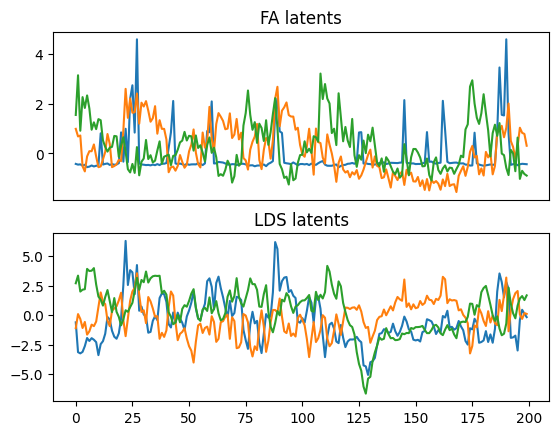

In [15]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(continuous_latents_fa[:200,:3])
plt.title('FA latents')
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(continuous_latents_lds[:200,:3])
plt.title('LDS latents')


D) At least to me, unlike the simulation example above, it's not obvious in thE above plots that the LDS model has smoother latents. In the text box below, why do you think LDS doesn't lead to such smooth responses here. (Hint: There are realistically multiple reasons, but I'm mainly looking for whether LDS is a good model for this data, which contains an entire experiment concatenated together).

# concatenation means that there possibly is different dynamics all stitched together. 

E) Still, let's quantitatively see how 'relatively smooth' the latents are. For each latent, we'll calculate the squared change in the latent at each time point, relative to the average squared magnitude of the latent. A smaller value will mean it's smoother (changing less from one time point to the next). We will then plot a histogram of this relative change. Run the below code cells

In [16]:
z=np.copy(continuous_latents_fa)
relative_change_fa=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_fa)

[0.9268308147094115, 0.31519297317905076, 0.4078397352216441, 0.6473556347113487, 0.5603215039781074, 0.8595340784409122, 0.9056872967698159, 0.9582738715313901, 1.020279877496159, 1.1797057824367314]


In [17]:
z=np.copy(continuous_latents_lds)
relative_change_lds=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_lds)

[0.3922999038987656, 0.40194763058637645, 0.15699162154983223, 0.4976856850636328, 0.33740550401596064, 0.36650842021655466, 0.21822905296603098, 0.17634306189178384, 0.4745422437760053, 0.15538163750744236]


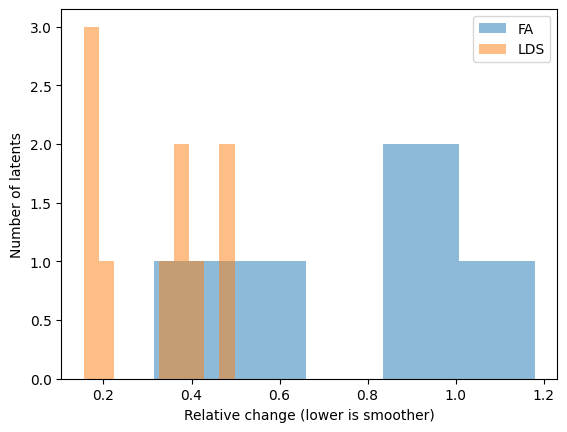

In [18]:
plt.hist(relative_change_fa,alpha=0.5)
plt.hist(relative_change_lds,alpha=0.5)
plt.xlabel('Relative change (lower is smoother)')
plt.ylabel('Number of latents')

plt.legend(['FA','LDS'])

F) Does LDS lead to smoother latents (Yes or No)? Answer in the text box below.

# yes 

G) One way to validate that we are getting a better estimate of the underlying latents is to try to see which set of latents best relates to a separate, external variable (here, velocity).

Fit decoding models from 1) the Factor analysis latents to velocity, and 2) the LDS latents to velocity, and see which leads to better performance.

In the decoding models, use latents that precede the velocity by 2 time bins (100 ms). That is, use Latents[:-2] to predict Velocity[2:]. This will improve decoding performance, since there is a lag for motor cortical signals to be maximally predictive of movement velocity.

For the sake of time, you can do this is a non-rigorous (non-cross-validated way). Just report the "score" (R2 value) from two sci-kit learn linear regression models, where you train on all of the data.

In [24]:
#Fit linear regression model based on factor analysis latents
LR_fa = LinearRegression()
LR_fa.fit(continuous_latents_fa[:-2], Velocity[2:])
print(LR_fa.score(continuous_latents_fa[:-2], Velocity[2:]))



0.4873635557257256


In [25]:
#Fit linear regression model based on LDS latents
#Fit linear regression model based on factor analysis latents
LR_lds = LinearRegression()
LR_lds.fit(continuous_latents_lds[:-2], Velocity[2:])
print(LR_lds.score(continuous_latents_lds[:-2], Velocity[2:]))



0.5894919468247877


### PLDS Models

G) Now we'll fit a Poisson Linear Dynamical system to the data. You can just run the code below.

In [26]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
latent_dim=10

#Declare the PLDS model
lds = ssm.LDS(obs_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the PLDS model
elbos, q = lds.fit(Neural_data.astype(int), method="laplace_em", num_iters=10)

#Get the latents:
continuous_latents_plds = q.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Plot the ELBO over model iterations to check that the model has converged. You can just run the code below.

Text(0, 0.5, 'ELBO')

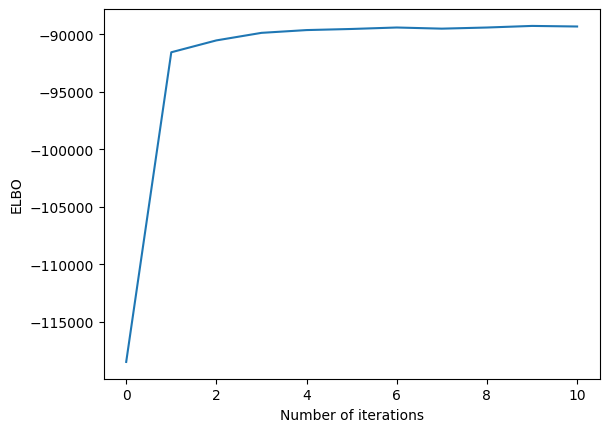

In [27]:
plt.plot(elbos)
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

H) Decode velocity based on the PLDS latents (again, with a lag of 2 time bins), in order to see how this compares to the LDS latents. Report the "score" (R2 value). Note that the value will be approximately the same here as what you got for LDS - when fitting the LDS/PLDS model with many more data points, a small difference starts to emerge. Note that a likely reason for the limited difference is the large time bins (50ms), and when there are many spikes within a time bin, a Gaussian approximation to a Poisson distribution is reasonable.

In [29]:
#Fit linear regression model based on PLDS latents
lr_plds = LinearRegression()
lr_plds.fit(continuous_latents_plds[:-2], Velocity[2:])
print(lr_plds.score(continuous_latents_plds[:-2], Velocity[2:]))


0.600823270244643


I) Plot the first 3 latents found with PLDS relative to LDS. To do so, fill in the code below.

Text(0.5, 1.0, 'LDS latents')

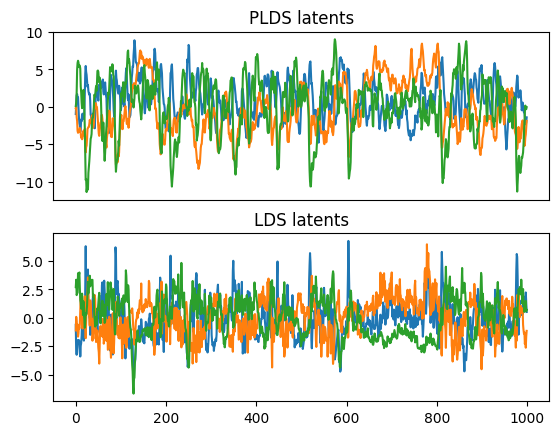

In [32]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(continuous_latents_plds[:,:3])
plt.title('PLDS latents')
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(continuous_latents_lds[:,:3])
plt.title('LDS latents')

In [34]:
z=np.copy(continuous_latents_lds)
relative_change_lds=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_lds)

[0.3922999038987656, 0.40194763058637645, 0.15699162154983223, 0.4976856850636328, 0.33740550401596064, 0.36650842021655466, 0.21822905296603098, 0.17634306189178384, 0.4745422437760053, 0.15538163750744236]


In [35]:
z=np.copy(continuous_latents_plds)
relative_change_plds=[np.mean((z[1:,l]-z[:-1,l])**2)/np.mean(z[:,l]**2) for l in range(latent_dim)]
print(relative_change_plds)

[0.12021331871976351, 0.04351897118772485, 0.09465226182193429, 0.1054863169357111, 0.08243455830306898, 0.2626965675919453, 0.09295062082197443, 0.10880710290186746, 0.22727641107286728, 0.08505981609480583]


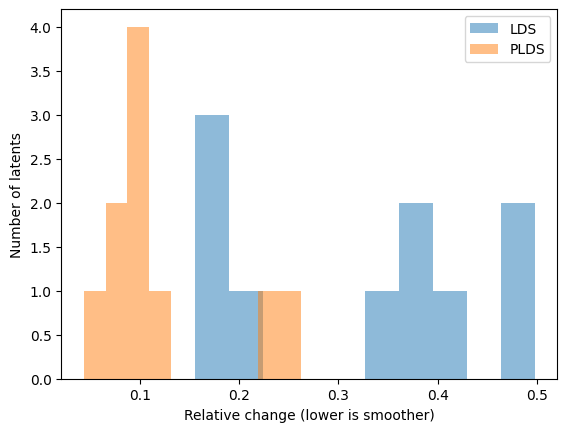

In [37]:
plt.hist(relative_change_lds,alpha=0.5)
plt.hist(relative_change_plds,alpha=0.5)
plt.xlabel('Relative change (lower is smoother)')
plt.ylabel('Number of latents')

plt.legend(['LDS','PLDS'])

J) Quantitatively determine how the relative smoothness of the latents found with PLDS compare to that of LDS. Create a histogram of the "relative change" of each latent for LDS and PLDS (you can mostly copy the code from above when you compared FA and LDS).

### SLDS models

K) Run an SLDS model with 2 discrete states, with a Poisson emissions model. You can just run the code below.

In [38]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
discrete_dim=2
latent_dim=10

#Declare the SLDS model
slds2 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the SLDS model
slds2_elbos, q_lem = slds2.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

L) Plot the ELBO over iterations, so you can get an idea that the model has converged. You can just run the code below.

Text(0, 0.5, 'ELBO')

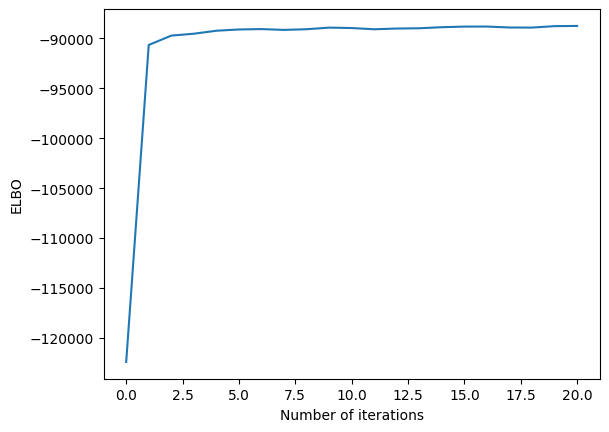

In [39]:
plt.plot(slds2_elbos)
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

We will also create the same plot starting at the second iteration to see more clearly whether it has converged.

Text(0, 0.5, 'ELBO')

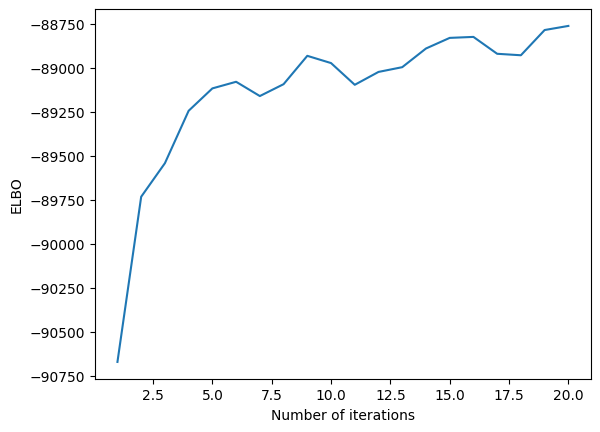

In [40]:
plt.plot(np.arange(1,20.1),slds2_elbos[1:])
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

M) Decode velocity based on the SLDS latents, in order to see how this compares to the previous LDS/PLDS latents (again with a lag of 2 time bins). Report the "score" (R2 value)

In [ ]:
#Fit linear regression model based on SLDS latents


In [41]:
#Fit linear regression model based on SLDS latents
lr_slds = LinearRegression()
lr_slds.fit(continuous_latents_slds[:-2], Velocity[2:])
print(lr_slds.score(continuous_latents_slds[:-2], Velocity[2:]))


0.6268902358674906


N) Run the code below to get the most likely states of the SLDS model, and plot them. We will plot the states over the behavioral velocity traces.

In [42]:
discrete_latents_slds = slds2.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

(0.0, 1000.0)

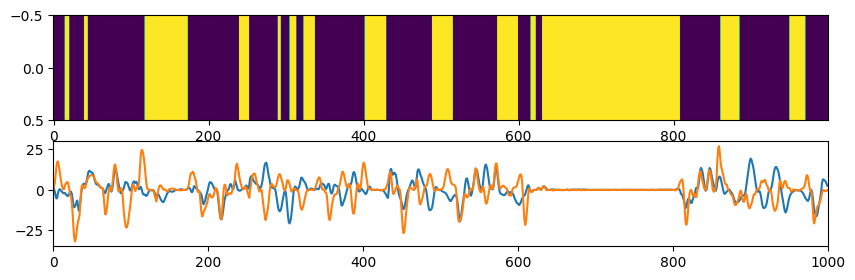

In [43]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])

O) In the text box below, write what behaviors the discrete states seem to belong to.

# not-reaching vs reaching

P) Fit an SLDS model with 3 discrete states.

In [44]:
np.random.seed(1)

obs_dim=Neural_data.shape[1]
discrete_dim=3
latent_dim=10

#Declare the LDS model
slds3 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the LDS model
slds3_elbos, q_lem = slds3.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Q) Plot the most likely discrete states on top of the velocity traces, as before.

In [45]:
discrete_latents_slds3 = slds3.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

(0.0, 1000.0)

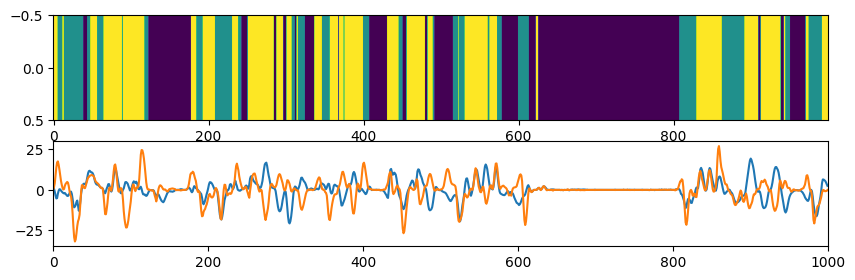

In [46]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds3[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])

R) Is it clear what the 3 states relate to? Enter in the text box below.

# purple is doing nothing, teal is actively reaching, yellow is doing something else

S) Which SLDS model (the one with 2 or 3 discrete states) had a better fit to the training data, in terms of their ELBO. Print out the elbo value on the final iteration for the two models (this will be the last entry in 'slds2_elbos', for example), and then in the text box, state which is higher.

Text(0, 0.5, 'ELBO')

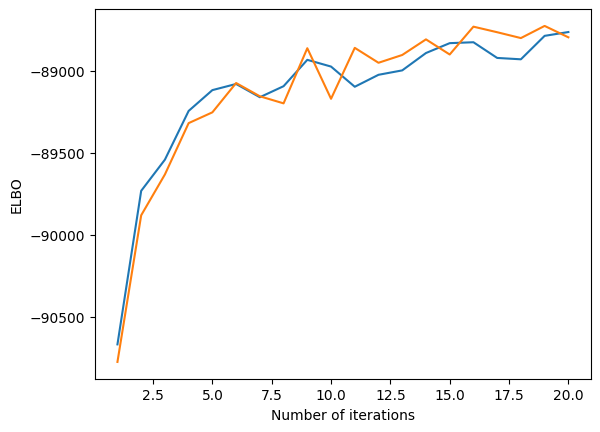

In [51]:
plt.plot(np.arange(1,20.1),slds2_elbos[1:])
plt.plot(np.arange(1,20.1),slds3_elbos[1:])
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')

# two states is enough

T) In the code below, we'll define a held-out test set as the next 1000 time points in the file. We will get the elbo on the held out data in the code below, which approximates the posterior (the latents) of the held out data, based on the already-fit-model's parameters, and then determines the elbo based on these test-set latents. After running the below code, print out the elbo value on the final iteration for the two models on the test set (e.g. slds2_test_elbos[-1]), and in the text box write which model is better.

In [52]:
Neural_data_test=Neural_data_tmp[1000:2000]

In [53]:
slds2_test_elbos, posterior = slds2.approximate_posterior(Neural_data_test.astype(int),
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
slds3_test_elbos, posterior = slds3.approximate_posterior(Neural_data_test.astype(int),
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
print(slds2_test_elbos[-1])
print(slds3_test_elbos[-1])

# two is still better

-92907.53896993876
-93490.10250245313


U) Finally, it is important to note that based on different random initializations, SLDS models can lead to differing results, and it's therefore valuable to test multiple models. Below is an SLDS model with 2 states with a different random seeds. It leads to a substantially worse training elbo, and qualitatively less sensible discrete states. Just run the code below to see this for yourselves.

In [57]:
np.random.seed(0)

obs_dim=Neural_data.shape[1]
discrete_dim=2
latent_dim=10

#Declare the SLDS model
slds2_v2 = ssm.SLDS(obs_dim, discrete_dim, latent_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

#Fit the SLDS model
slds2_v2_elbos, q_lem = slds2.fit(Neural_data.astype(int), method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=20, alpha=0.0)
#Get the continuous latents:
continuous_latents_slds = q_lem.mean_continuous_states[0]

#Get the discrete latents
discrete_latents_slds = slds2_v2.most_likely_states(continuous_latents_slds, Neural_data.astype(int))

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
print('Previous Model 2 state training elbo:', slds2_elbos[-1])
print('New Model 2 state training elbo:', slds2_v2_elbos[-1])

Previous Model 2 state training elbo: -88762.237507315
New Model 2 state training elbo: -89145.33257390009


(0.0, 1000.0)

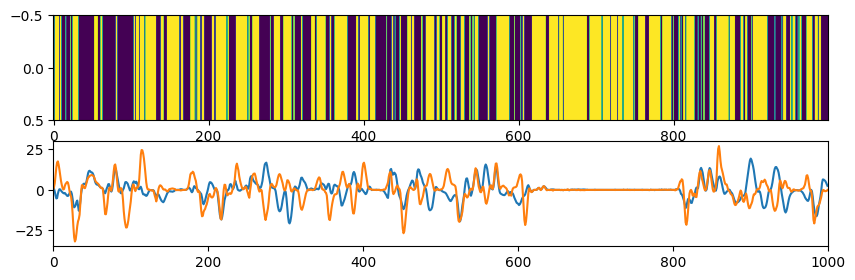

In [59]:
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.imshow(discrete_latents_slds[None,:1000],aspect='auto')
plt.subplot(2,1,2)
plt.plot(Velocity[:1000])
plt.xlim([0,1000])